<a href="https://colab.research.google.com/github/TurkuNLP/register-DeepL/blob/main/register_eng_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Testing making an english model with the downsampled data to get some sort of baseline for the downsampled and translated data**

Before running this notebook put the file in the directory.

In [ ]:
#!wget -nc https://github.com/TurkuNLP/register-DeepL/blob/main/AfterDeepL/es_FINAL.tsv.gz # the repo is private so this does not work lol

In [1]:
!pip3 install -q transformers datasets

In [2]:
import transformers
import datasets
import random
import re
import json

from pprint import PrettyPrinter
import logging
pprint = PrettyPrinter(compact=True).pprint
logging.disable(logging.INFO)

In [4]:
file_name = "en_train.downsampled.tsv"
data=[]
with open(file_name) as f:
    for line in f:
        line=line.rstrip("\n")
        if not line or line.startswith("#"): #skip empty and comments (incl. header)
            continue
        cols=line.split("\t")
        if len(cols)!=2: #skip weird lines that don't have the right number of columns
            continue
        data.append(cols)

pprint(data[0])

['NA OP',
 "On Tuesday night, Sarah Palin dropped by Bill O'Reilly 's show to discuss "
 'some recent comments by Laura Ingraham , as well as the approach the '
 'Romney/Ryan ticket should take in the home stretch of campaigning. Hammering '
 'home the argument that Mitt Romney needs to be more aggressive, Palin '
 'defined the election as a choice between "free stuff or freedom." Asked '
 "about Ingraham's remark that if the Republicans can't win this election, "
 'they should shut down the party, Palin, too, agreed that this is a election '
 "that should be working in Romney's favor. Rush Limbaugh similarly said the "
 "president's reelection would signal the end of the GOP. The issue, she said, "
 'is that the message is getting across to voters. "If you can\'t get your '
 'message through that filter of media, then we\'re in a world of hurt," she '
 'said. What Republicans are failing to do, she added, is explain that voters '
 'have a choice: "Free stuff or freedom. You cannot hav

In [5]:
random.seed(1234)
random.shuffle(data) 

In [6]:
# get a list of all the unique labels in the data using set which does not allow duplicates

labels = [one[0] for one in data]

labelset = set(labels) #split_labels
unique_labels=list(labelset)

#texts= [one[1] for one in data]
print(len(unique_labels))
print(unique_labels[:10])

29
['ID', 'HI', 'NA', 'ID SP', 'IN LY', 'OP ID', 'IN SP', 'NA SP', 'NA IP', 'OP LY']


In [8]:
with open("eng-downsampled-register-data.jsonl", "wt") as f:
    for cols in data:
        item = {
            "text": cols[1],
            "label": unique_labels.index(cols[0]), 
        }
        print(json.dumps(item,ensure_ascii=False,sort_keys=True),file=f)

In [9]:
file = "eng-downsampled-register-data.jsonl"
dataset = datasets.load_dataset(
    'json',                             
    data_files={"everything":file}, # I need the test set from Veronika? ask Filip and Veronika
    split={
        "train":"everything[:80%]",  
        "validation":"everything[80%:90%]",   
        "test":"everything[90%:]"    
    },
    features=datasets.Features({
        "label":datasets.ClassLabel(names=unique_labels),
        "text":datasets.Value("string")
    })
)


Using custom data configuration default-91502841b57930c9


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-91502841b57930c9/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
model_name = "xlm-roberta-base" # to get the base numbers for monolingual I could use bert-base instead of the crosslingual model (large, which takes forever to load)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(
        example["text"],
        max_length=512,
        truncation=True, # do something else other than truncating? the texts now have max 1024 tokens
    )

dataset = dataset.map(tokenize)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

  0%|          | 0/2230 [00:00<?, ?ex/s]

  0%|          | 0/279 [00:00<?, ?ex/s]

  0%|          | 0/279 [00:00<?, ?ex/s]

In [13]:
model = transformers.XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(unique_labels))

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [14]:
trainer_args = transformers.TrainingArguments(
    "checkpoints",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=0.00001,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    max_steps=1500
)

In [15]:
accuracy = datasets.load_metric("accuracy")

def compute_accuracy(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1) #pick the index of the "winning" label
    return accuracy.compute(predictions=predictions, references=labels)


data_collator = transformers.DataCollatorWithPadding(tokenizer)

In [16]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience=5
)

In [17]:
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_accuracy,
    data_collator=data_collator,
    tokenizer = tokenizer,
    callbacks=[early_stopping, training_logs]
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss,Validation Loss,Accuracy
100,2.984900,2.671216,0.125448
200,2.690800,2.461657,0.222222
300,2.432600,2.112425,0.451613
400,2.197700,1.948770,0.473118
500,2.142000,1.931420,0.462366
600,2.002100,1.777457,0.523297
700,1.841900,1.742053,0.541219
800,1.863000,1.730790,0.526882
900,1.808800,1.637932,0.523297
1000,1.639400,1.645738,0.519713


TrainOutput(global_step=1500, training_loss=1.9679575703938803, metrics={'train_runtime': 1482.006, 'train_samples_per_second': 8.097, 'train_steps_per_second': 1.012, 'total_flos': 3155466323159040.0, 'train_loss': 1.9679575703938803, 'epoch': 5.38})

In [18]:
eval_results = trainer.evaluate(dataset["test"])

print('Accuracy:', eval_results['eval_accuracy'])

Accuracy: 0.48028673835125446


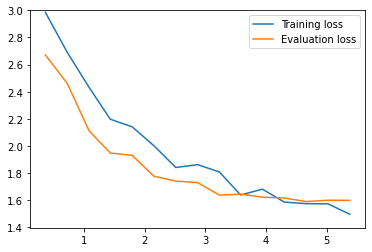

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 3.0))
    for key, label in zip(keys, labels):    
        plt.plot(logs["epoch"], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])

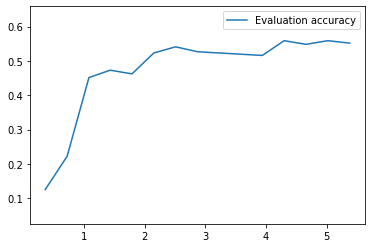

In [22]:
plot(training_logs.logs, ["eval_accuracy"], ["Evaluation accuracy"])

My thoughts:

1. One thing is that the big labels were made smaller which might affect the results because it does not guess the big label as much and get it right like it might do in the normal thing => test making a model with eng downsampled data?

2. => the eng downsampled result is around 55 for training and 48 for evaluation which is a bit lower than what the papers Veronika sent me had (70-80), this also means there is a lot of chance involved (like 50/50 whether the label is correct) but hopefully the multilabel will help.
3. Also would be best if the test set was from somewhere else? like the ready made test-set Veronika apparently has for the smaller languages

All in all, true multilabel is the only solution to this really and even then english data only having base labels might be an issue when the others have sublabels (this also depends on the target language test set and how the annotations are done)

